# Imports

In [72]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
from nltk import ngrams
from nltk import FreqDist
from sklearn.decomposition import LatentDirichletAllocation
from spellchecker import SpellChecker
# nltk.download('all')

In [73]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [74]:
#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# Functions

### 1. Data cleaning

In [75]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    clean_text = re.sub('\S*\d\S*\s*', '', clean_text)
    
    return clean_text

def remove_punctuation(text):
    punctuation = text.translate(str.maketrans('', '', string.punctuation))
    return punctuation

def convert_to_lowercase(text):
    text_lower = text.lower()
    return text_lower

def tokenization(text):
    tokens  = word_tokenize(text)

    return ' '.join(tokens)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
    

def lem_text(text):
    doc = nlp(text)
    lemma = ' '.join([token.lemma_ for token in doc])
    
    return lemma

def replace(text):
    replaced = text.replace('xxxx', '').replace('-PRON-', '')

    return replaced

def spell_correct(text):
    if text is None or not isinstance(text, str):
        return text

    spell = SpellChecker()

    # Find misspelled words
    misspelled = spell.unknown(text.split())

    # Correct misspelled words
    corrected_text = [spell.correction(word) if word in misspelled else word for word in text.split()]
    
    try:
        return ' '.join(corrected_text)
    except:
        return ' '.join(text)



### 2. Merge cleaning functions for one function

In [76]:
def preprocessing_data(text):
    
    text = remove_special_characters(text) #pass
    text = remove_punctuation(text) #pass
    text = convert_to_lowercase(text) #pass
    text = tokenization(text) #pass
    text = remove_stopwords(text) #pass
    text = lem_text(text) #pass
    text = replace(text) #pass
    return text

### 3. Restore basic forms of words

In [77]:
def lemmatization(text):
    doc = nlp(text)
    lem_tokens = [token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS]
    return ' '.join(lem_tokens)
    
    # return lem_text

def stemming(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in words if word.text.lower() not in STOP_WORDS]
    return ' '.join(stem_words)

    # return stem_text

def remove_POS_tags(text):
    doc = nlp(text)
    result = [token.text for token in doc if token.tag_ == 'NN']  # check for nouns
    return ' '.join(result)
    # return remove_pos


#Write your function to extract the POS tags NN
# def extract_pos_tags(text):
#     doc = nlp(text)
#     sent = [token.text for token in doc if token.tag_ == 'NN']
#     return ' '.join(sent)

# finding ngrams

In [78]:
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return list(n_grams)

def get_top_ngrams(data, n, top=30):
    combined_text = ' '.join(data.astype(str))
    n_grams = get_ngrams(combined_text, n)
    freq_dist = FreqDist(n_grams)
    return freq_dist.most_common(top)

# Importing data 

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [79]:
path = "complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [80]:
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})

# data modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)
df[df['complaint_text']==''] = np.nan
df = df[~df['complaint_text'].isnull()]

# text cleaning

In [81]:

data = df # replace to have possibility to load back original data
data['clean'] = data['complaint_text'].apply(lambda x: preprocessing_data(x)) # new column with preprocessed data
data['clean'] = data['clean'].apply(lambda x: lemmatization(x))
data['clean'] = data['clean'].apply(lambda x: remove_POS_tags(x))
data.head()

,complaint_text,category,clean
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,morning help bank service write chase debt ver...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,son deposit chase account fund account money s...


### Check data

(array([9.072e+03, 6.363e+03, 2.798e+03, 1.269e+03, 8.000e+02, 3.080e+02,
        1.470e+02, 8.400e+01, 6.100e+01, 3.800e+01, 3.700e+01, 1.600e+01,
        1.400e+01, 1.300e+01, 7.000e+00, 8.000e+00, 6.000e+00, 3.000e+00,
        2.000e+00, 3.000e+00, 8.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0.  ,   247.14,   494.28,   741.42,   988.56,  1235.7 ,
         1482.84,  1729.98,  1977.12,  2224.26,  2471.4 ,  2718.54,
         2965.68,  3212.82,  3459.96,  3707.1 ,  3954.24,  4201.38,
         4448.52,  4695.66,  4942.8 ,  5189.94,  5437.08,  5684.22,
         5931.36,  6178.5 ,  6425.64,  6672.78,  6919.92,  7167.06,
         7414.2 ,  7661.34,  7908.48

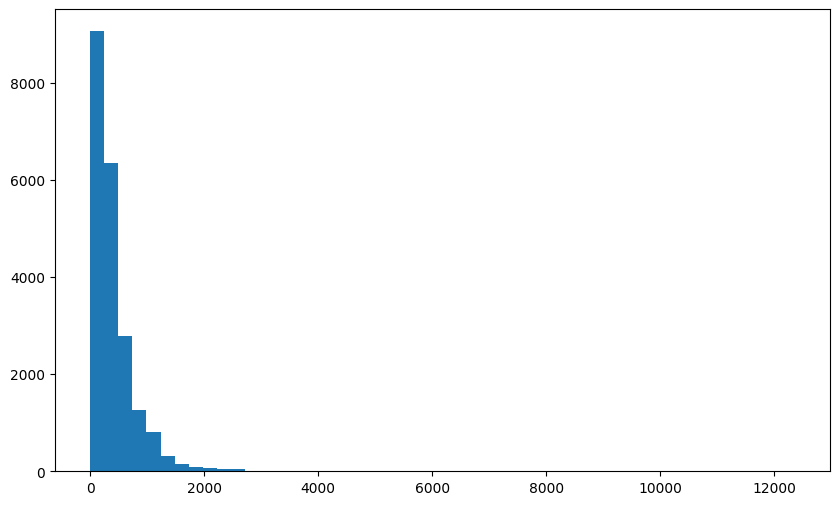

In [82]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
# doc_lens = [len(d) for d in data.clean]
doc_lens = [len(d) for d in data.clean]
plt.hist(doc_lens, bins = 50)

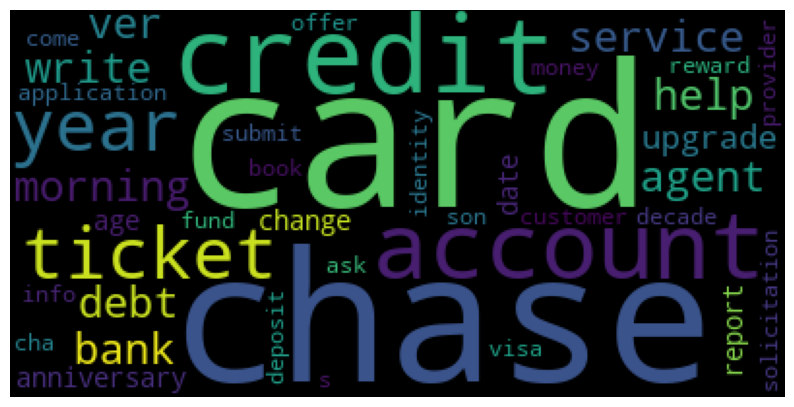

In [83]:

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['clean']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [84]:
data.head(20)

,complaint_text,category,clean
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,morning help bank service write chase debt ver...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,son deposit chase account fund account money s...
15,Can you please remove inquiry,"Credit reporting, credit repair services, or o...",inquiry
17,With out notice J.P. Morgan Chase restricted m...,Checking or savings account+Checking account,account debit card branch customer service rep...
20,"During the summer months, I experience a decli...",Vehicle loan or lease+Loan,summer month experience income employment requ...
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...","Money transfer, virtual currency, or money ser...",payment retailer chase pay chase website scam ...
23,I have a Chase credit card which is incorrectl...,Credit card or prepaid card+General-purpose cr...,chase credit card datum credit report company ...


# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM or LDA
###
###
###

##### vectorizer - TFIDF

In [85]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = vectorizer.fit_transform(data['clean']) # document term metrix
# vectorizer.get_feature_names_out()[:10]

In [86]:
dtm

<21072x6906 sparse matrix of type '<class 'numpy.float64'>'
	with 683659 stored elements in Compressed Sparse Row format>

### Finding top n-grams

In [87]:
top_unigrams = get_top_ngrams(data['clean'], 1)
top_bigrams = get_top_ngrams(data['clean'], 2)
top_trigrams = get_top_ngrams(data['clean'], 3)

In [88]:
top_unigrams[:5]

[(('chase',), 59632),
 (('account',), 43422),
 (('credit',), 33888),
 (('card',), 30227),
 (('payment',), 21160)]

In [89]:
top_bigrams[:5]

[(('credit', 'card'), 12839),
 (('credit', 'report'), 3980),
 (('chase', 'credit'), 3425),
 (('check', 'account'), 3216),
 (('customer', 'service'), 2991)]

In [90]:
top_trigrams[:5]

[(('chase', 'credit', 'card'), 2462),
 (('credit', 'card', 'account'), 1063),
 (('credit', 'card', 'company'), 983),
 (('credit', 'card', 'chase'), 825),
 (('chase', 'customer', 'service'), 566)]

### Vectorizer - TF-IDF

In [129]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
dtm = vectorizer.fit_transform(data['clean']) # document term metrix
feature_names = np.array(vectorizer.get_feature_names_out())

### NFM

In [126]:
# nfm = NMF(n_components=5, random_state=40)
# nfm.fit(dtm)

# # change dtype from object to int
# feature_mapping = {feature: idx for idx, feature in enumerate(feature_names)}
# features_int = [feature_mapping[feature] for feature in feature_names]

# for index,topic in enumerate(nfm.components_):
#     top_words_indices = topic.argsort()[-15:]
#     top_words = [features_int[i] for i in top_words_indices]

# topics = nfm.transform(dtm)
# dominant_topics = topics.argmax(axis=1)
# data['Topic_NFM'] = dominant_topics

# # print data
# for index,topic in enumerate(nfm.components_):
#     print("top 15 words for topic",  index)
#     print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
#     print('\n')

top 15 words for topic 0
['customer', 'claim', 'business', 'number', 'transaction', 'transfer', 'day', 'branch', 'fund', 'chase', 'deposit', 'money', 'bank', 'check', 'account']


top 15 words for topic 1
['refund', 'time', 'balance', 'fraud', 'use', 'merchant', 'service', 'transaction', 'purchase', 'fee', 'dispute', 'credit', 'chase', 'charge', 'card']


top 15 words for topic 2
['refinance', 'sale', 'foreclosure', 'request', 'rate', 'time', 'document', 'letter', 'year', 'property', 'modification', 'home', 'chase', 'mortgage', 'loan']


top 15 words for topic 3
['limit', 'application', 'identity', 'remove', 'chase', 'information', 'reporting', 'debt', 'company', 'score', 'account', 'card', 'inquiry', 'report', 'credit']


top 15 words for topic 4
['mortgage', 'year', 'account', 'credit', 'date', 'auto', 'chase', 'time', 'day', 'statement', 'fee', 'month', 'pay', 'balance', 'payment']




# test

In [137]:
# Step 1: Vectorize text data
from sklearn.cluster import KMeans
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['clean'])

# Step 2: Apply K-Means clustering
num_clusters = 5  # Set the number of clusters (new categories)
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Step 3: Manually assign representative category names to clusters
cluster_representative_names = ["New Category 1", "New Category 2", "New Category 3", "New Category 4", "New Category 5"]
data['new_category'] = data['cluster'].map(lambda cluster_id: cluster_representative_names[cluster_id])

# Step 4: Update DataFrame
data = data.drop(columns=['cluster'])  # Drop the temporary cluster column if not needed

# Display the updated DataFrame

In [138]:
data.head()

,complaint_text,category,clean,Topic_NFM,new_category
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,morning help bank service write chase debt ver...,1,New Category 3
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...,0,New Category 3
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...,4,New Category 3
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...,4,New Category 4
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,son deposit chase account fund account money s...,0,New Category 5


In [130]:
model  = NMF(n_components=5, init='random', random_state=0)
W, H = model .fit_transform(dtm), model .components_
num_topics = model.n_components
num_documents = len(data.clean)

top_words = [feature_names[np.argsort(topic)[-5:][::-1]] for topic in H.T]
topics_nmf = [' '.join(words) for words in top_words]

In [148]:
# topic_col  = ["Topic" + str(i) for i in range(num_topics)]
# doc_names = ["Doc" + str(i) for i in range(num_documents)]
col=[]
for num1 in range(5):
    col.append("Topic_" + str(num1))

doc=[]
for num2 in range(5):
    doc.append("Doc_" + str(num2))

df_main_topic = pd.DataFrame(np.round(W, 2), columns=col, index=doc)
main_topic = np.argmax(df_main_topic.values, axis=1)
df_main_topic['dominant_topic'] = main_topic
df_main_topic.head()

ValueError: Shape of passed values is (21072, 5), indices imply (5, 5)

In [132]:
data['Topic_NFM'] = main_topic

In [133]:
data.head()

,complaint_text,category,clean,Topic_NFM
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt,morning help bank service write chase debt ver...,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...,0
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...,4
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...,4
14,my grand son give me check for {$1600.00} i de...,Checking or savings account+Checking account,son deposit chase account fund account money s...,0


In [134]:
# lda = LatentDirichletAllocation(n_components=5, random_state=42)
# lda.fit(dtm)

# # Map feature names to integer indices
# feature_mapping = {feature: idx for idx, feature in enumerate(feature_names)}
# features_int = [feature_mapping[feature] for feature in feature_names]

# # Print top words for each topic
# for index, topic in enumerate(lda.components_):
#     top_words_indices = topic.argsort()[-15:]
#     top_words = [features_int[i] for i in top_words_indices]

# # Transform the document-term matrix using the LDA model
# topics = lda.transform(dtm)

# # Get dominant topics for each document
# dominant_topics = topics.argmax(axis=1)

# # Add a 'Topic' column to the DataFrame
# data['Topic_LDA'] = dominant_topics

# for index,topic in enumerate(nfm.components_):
#     print("top 15 words for topic",  index)
#     print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
#     print('\n')

In [139]:
example_data =data[['complaint_text','clean','category','new_category']].groupby('new_category').head(10)
example_data.sort_values('new_category')

,complaint_text,clean,category,new_category
213,My mortgage is with Chase. My payments were be...,mortgage chase payment month provider chase tr...,Mortgage+VA mortgage,New Category 1
203,"JP Morgan and Chase reported 3 loans ( $ XXXX,...",loan debt behalf address use report cosigner a...,Student loan+Private student loan,New Category 1
82,I recently called to ask Chase bank why they r...,report day payment pay info bill owe balance f...,Debt collection+Credit card debt,New Category 1
86,"A student loan with Chase bank, they sold ther...",student loan chase bank sell account account a...,Student loan+Private student loan,New Category 1
58,I made a purchase of {$260.00} on XX/XX/XXXX. ...,payment payment closing date statement stateme...,Credit card or prepaid card+General-purpose cr...,New Category 1
20,"During the summer months, I experience a decli...",summer month experience income employment requ...,Vehicle loan or lease+Loan,New Category 1
99,My name is XXXX XXXX. I have missed a payment ...,payment day current time loan modification los...,Mortgage+Conventional home mortgage,New Category 1
141,Action Taken By The Company Between the dates ...,action company date group contact chase claim ...,Checking or savings account+Checking account,New Category 1
156,Chase issued a mortgage loan against my proper...,chase issue mortgage loan property contact hom...,Mortgage+FHA mortgage,New Category 1
57,I have been trying to do a loan modification w...,loan modification chase payment,Mortgage+Conventional home mortgage,New Category 1


In [124]:
example_data = data[['complaint_text','clean','category','Topic_NFM']].groupby('Topic_NFM').head(10)
example_data.sort_values('Topic_NFM')

,complaint_text,clean,category,Topic_NFM
27,I opened an account with chase bank on XXXX an...,account bank code bonus follow term tell accou...,Checking or savings account+Checking account,0
103,On XX/XX/XXXX I received an advertisement via ...,advertisement email chase customer chase check...,Checking or savings account+Checking account,0
14,my grand son give me check for {$1600.00} i de...,son deposit chase account fund account money s...,Checking or savings account+Checking account,0
101,I Purchase is an airline ticket on XX/XX/XXXX ...,airline ticket dollar airport ticket hour post...,Checking or savings account+Checking account,0
17,With out notice J.P. Morgan Chase restricted m...,account debit card branch customer service rep...,Checking or savings account+Checking account,0
42,My card went missing and i didnt realize it un...,card today email deposit bank account,Checking or savings account+Checking account,0
92,"In XX/XX/2019, several transactions on my Chas...",transaction chase check account file report ch...,Debt collection+I do not know,0
24,mishandling of this account by Chase auto and ...,mishandle account chase auto,Vehicle loan or lease+Loan,0
69,Someone called stating I had felony committed ...,state felony security number account asset sta...,Checking or savings account+Checking account,0
35,I opened the saving account for the {$25.00} b...,bonus auto transfer check saving notice transf...,Checking or savings account+Savings account,0


In [140]:
data.new_category.value_counts()

new_category
New Category 3    7679
New Category 5    4465
New Category 2    3809
New Category 1    3494
New Category 4    1625
Name: count, dtype: int64